# Matthew Joel
## Building a Spam Filter

In [ ]:
import re
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

The purpose of this project is to train a classifier to detect email spams (spam $y=1$, non-spam $y=0$).

First, we need to change any text email to numerical values (a feature vector $\boldsymbol{x}\in\mathbb{R}^n$). We walk through the steps of constructing such a vector from an email.

## Preprocessing Emails

The file named "email1.txt" contains an example email that contains words, numbers, an email address, a URL, special letters (e.g. the dollar sign). Since many emails may contain numbers, email addresses, URLs, special letters, it is common practice to "normalize" these values, so that all email addresses, URLs, etc. are treated the same. For example, we can replace any URL with a special string "httpaddress" to indicate a URL exists. The purpose is to let the spam classifier know a URL is present, instead of what the URL is. Following this idea, we will implement the following steps for any raw email:

1. Lower-casing: convert all letters to lower case
2. Normalizing URLs: All URLs are replaced with the text "httpaddr".
3. Normalizing email addresses: Replace all email addresses with the text "emailaddr"
4. Normalizing numbers: Replace all numbers with the text "number".
5. Normalizing Dollars: Replace all dollar signs $\$$ with the text "dollar".
6. Stemming words: For example, "replacing", "replaces", "replaced" are all replaced with "replace"
7. Removing non-words: Remove non-words and punctuations. All white spaces (tabs, newlines ('\n'), spaces) should be trimmed to a single space character.

To achieve all the 7 steps, we look at an example. Read in "email1.txt" as a single string:

In [ ]:
email = open('email1.txt', 'r').read()
email

"> Anyone knows how much it costs to host a web portal ?\n>\nWell, it depends on how many visitors you're expecting.\nThis can be anywhere from less than 10 bucks a month to a couple of $100. \nYou should checkout http://www.rackspace.com/ or perhaps Amazon EC2 \nif youre running something big..\n\nTo unsubscribe yourself from this mailing list, send an email to:\ngroupname-unsubscribe@egroups.com\n\n"

Here are the codes to realize all the steps above in Python. Suppose we have a string variable named str1.

1. str1.lower() converts all uppercase characters in str1 into lowercase characters (note that str1 itself does not change.)
2. Replace URLs by: re.sub(r'(http|https)://[^\s]*', 'httpaddr', str1)
3. Replace email addresses by: re.sub('[^\s]+@[^\s]+', 'emailaddr', str1);
4. Replace all numbers by: re.sub('[0-9]+', 'number', str1)
5. Replace dollar sign by: re.sub('[$]+', 'dollar', str1)
6. Word Stemming: first build a PorterStemmer class by: ps = PorterStemmer(), then stemming the words by:

str1 = " ".join([ps.stem(word) for word in str1.split()])

7. Remove non-words and punctuations by:
re.sub(r'[\'\"@$%/#.:,&*+=?!\[\](){}>_<]', '', str1). Trim white spaces to a single space character by: re.sub(r'\s+',' ', str1)

Finally strip the string (remove spaces at the beginning and at the end of the string) by:
str1 = str1.strip()

In [ ]:
import re
from nltk.stem import PorterStemmer

def ProcessEmail(emailstring):
    """
    Process the 7 steps above for an email string
    input: emailstring: the string that contains the email content. type: string
    return: a string that is the processed email content
    """
    # 1
    emailstring = emailstring.lower()

    # 2
    emailstring = re.sub(r'(http|https)://[^\s]*', 'httpaddr', emailstring)

    # 3
    emailstring = re.sub('[^\s]+@[^\s]+', 'emailaddr', emailstring)

    # 4
    emailstring = re.sub('[0-9]+', 'number', emailstring)

    # 5
    emailstring = re.sub('[$]+', 'dollar', emailstring)

    # 6
    ps = PorterStemmer()
    emailstring = " ".join([ps.stem(word) for word in emailstring.split()])

    # 7
    emailstring = re.sub(r'[\'\"@$%/#.:,&*+=?!\[\](){}>_<]', '', emailstring)
    emailstring = re.sub(r'\s+', ' ', emailstring)

    emailstring = emailstring.strip()

    return emailstring

email = open('email1.txt', 'r').read()
processed_email = ProcessEmail(email)
print(processed_email)


anyon know how much it cost to host a web portal well it depend on how mani visitor your expecting thi can be anywher from less than number buck a month to a coupl of dollarnumber you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr


## Vocabulary List

After the emails are preprocessed, we now have a string that contains a list of words for
each email. In the next step, we choose the words we would like to use in our classifier and ignore the rest. Suppose, based on a large number of email samples, we have already chosen the most frequently occuring words as the set of words to be considered, known as the vocabulary list, which is stored in vocab.txt.

In [ ]:
vocab = pd.read_csv('vocab.txt', delim_whitespace=True, names=['index', 'word'])
vocab.head(10)

,index,word
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
5,6,abov
6,7,absolut
7,8,abus
8,9,ac
9,10,accept


Each word has an index.

Given the vocabulary list, we can now map each word in the preprocessed emails into a list of indices, each of which is the index of the word in the vocabulary list. Specifically, in the sample email, the word "anyon" can be mapped onto the index 86 in the vocabulary
list. If a word is not in the vocabulary, ignore it. Now we write a function in the following form:

In [ ]:
def EmailToIndices(processed_email, vocab_df):
    """
    Turn processed email string to a list of indices
    input: processed_email: a string of preprocessed email
           vocab_df: the vocabulary data frame
    return: a list of integers, which are the indices of the words in the vocabulary list
    """
    words = processed_email.split()
    indices = []

    for word in words:
        if word in vocab_df['word'].values:
            index = vocab_df[vocab_df['word'] == word]['index'].values[0]
            indices.append(index)

    return indices

indices = EmailToIndices(processed_email, vocab)
print(indices)

[86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1895, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


## Extracting Features from Emails

Now we will convert each email into a vector in $R^n$ as the features, where $n$ is the number of words in the vocabulary list. Specifically, the feature $x_i=0$ or $1$ for an email depending on whether the $i$-th word in the vocabulary list occurs in the email. That is, $x_i = 1$ if the $i$-th word is in the email and $x_i = 0$ if the i-th word is not present in the email. Here's a function that converts a list of indices obtained from the previous function to a feature vector in $R^n$.

In [ ]:
def FeatureExtraction(indices, vocab_df):
    """
    Convert a list of word indices to a feature vector
    input: indices: a list of integer, which are the indices of the words in the email
           vocab_df: the vocabulary data frame
    return: a one-dimensional numpy array that contains the features. The size of the
            array is equal to the number of rows of the vocabulary data frame
    """
    n = len(vocab_df)
    feature_vector = np.zeros(n)

    for index in indices:
        if index - 1 < n:
            feature_vector[index - 1] = 1

    return feature_vector

feature_vector = FeatureExtraction(indices, vocab)
num_nonzeros = np.sum(feature_vector)
size_of_vector = len(feature_vector)
print(f"Number of nonzeros: {num_nonzeros}")
print(f"Size of vector: {size_of_vector}")

Number of nonzeros: 42.0
Size of vector: 1899


## Training SVM for Spam Classification

Now suppose we have preprocessed a bunch of emails and manually labled them. Each original email was processed using the ProcessEmail, EmailToIndices, and FeatureExtraction functions in sequence, and converted into a vector in $R^{1899}$. We use the data to train a Linear SVM classifier. The file "spamTrain.npy" contains 4000 training examples of spam and non-spam email, while "spamTest.npy" contains 1000 test examples. The last column is the target label (spam: y=1, non-spam: y=0). Use np.load(filename) to read in the data.

1. For training the linear SVM, consider $C=\{0.05, 1.0, 2.0\}$. Set random_state=10, loss='hinge', and all the other parameters are by default. For each model report the accuracy on the test data (LinearSVC has a built in function to calculate accuracy). Also report the best model based on the accuracy values.

2. Look at the parameters $\boldsymbol{w}=\{w_1,w_2,\dots,w_n\}$ of the underlying linear model. Make a plot of the absolute values of $\boldsymbol{w}$ versus the indices $[0,1,2,...n-1]$. Are some weights $w_i$ significantly larger than the rest of the weights from the graph? If so, the words corresponding to the larger weights are the most predictive of spam. We will find those words. To do this, let's find the indices (positions) of the 15 largest values in the vector $\boldsymbol{w}$, with the function np.argsort. Then use the indices to find the words in the vocabulary data frame.

In [ ]:
#1.
spamTrain = np.load('spamTrain.npy')
# NOTE! training file is too large for github
spamTest = np.load('spamTest.npy')

X_train, y_train = spamTrain[:, :-1], spamTrain[:, -1]
X_test, y_test = spamTest[:, :-1], spamTest[:, -1]

C_values = [0.05, 1.0, 2.0]
models = {}

for C in C_values:
    svm_model = LinearSVC(C=C, random_state=10, loss='hinge')
    svm_model.fit(X_train, y_train)
    accuracy = svm_model.score(X_test, y_test)
    print(f'C = {C}: Accuracy = {accuracy}')

C = 0.05: Accuracy = 0.992
C = 1.0: Accuracy = 0.977
C = 2.0: Accuracy = 0.974


$C = 0.05$ had the best accuracy of 0.992.

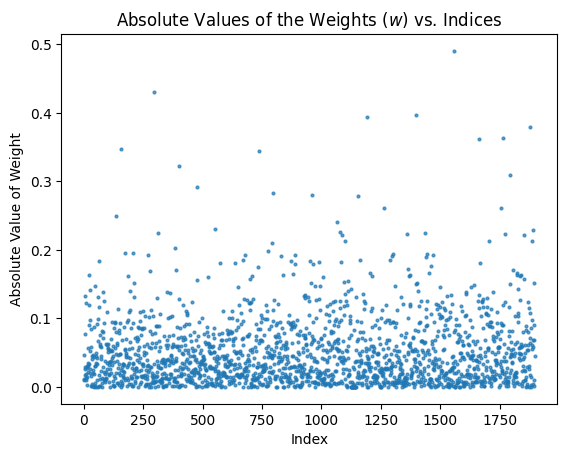

(array([1560,  297, 1397, 1190, 1880, 1764, 1665,  155,  738,  400, 1795,
         476,  798,  960, 1152]),
 array(['spamassassin', 'click', 'remov', 'our', 'wrote', 'url', 'the',
        'basenumb', 'guarante', 'date', 'visit', 'dollar', 'httpaddr',
        'list', 'numbertnumb'], dtype=object))

In [ ]:
best_model = LinearSVC(C=0.05, random_state=10, loss='hinge')
best_model.fit(X_train, y_train)

plt.plot(np.abs(best_model.coef_[0]), marker='o', linestyle='none', markersize=2, alpha=0.7)
plt.title('Absolute Values of the Weights ($w$) vs. Indices')
plt.xlabel('Index')
plt.ylabel('Absolute Value of Weight')
plt.show()

largest_weights_indices = np.argsort(-np.abs(best_model.coef_[0]))[:15]
words_from_indices = vocab.iloc[largest_weights_indices]['word'].values
largest_weights_indices, words_from_indices